# Fine Tuning with Transfer Learning

> This is another type(Fine Tuning) of transfer Learning. First we did **Feature extration** which is another type of transfer learning


**Keras Sequential VS Function API** -> https://www.youtube.com/watch?v=EvGS3VAsG4Y 

**Docs** -> https://www.tensorflow.org/guide/keras/functional

In [1]:
import tensorflow as tf

IMG_SIZE=(224,224)
BATCH_SIZE=32

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-07-29 14:18:38--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-07-29 14:18:38 (77.4 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

## Getting the data

In [4]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

--2022-07-29 14:18:38--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.145.128, 74.125.128.128, 173.194.69.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.145.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  76.4MB/s    in 2.1s    

2022-07-29 14:18:41 (76.4 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [5]:
unzip_data('10_food_classes_10_percent.zip')

In [6]:
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent

In [7]:
train_dir= "10_food_classes_10_percent/train"
test_dir='10_food_classes_10_percent/test'

In [8]:
len(train_dir), len(test_dir)

(32, 31)

In [9]:
train_data=tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,image_size=IMG_SIZE, label_mode="categorical", batch_size=BATCH_SIZE)

test_data=tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,image_size=IMG_SIZE, label_mode="categorical", batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [10]:
len(train_data)

24

In [11]:
train_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [12]:
train_data.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [13]:
len(train_data.class_names)

10

In [14]:
train_data.take

<bound method DatasetV2.take of <BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>>

## Another Way to Build models

> We are using the **tf.keras.applications** or the **Keras Functional** API to build a model

Link -> https://www.tensorflow.org/api_docs/python/tf/keras/applications

> The Sequential API is straight-forward, it runs our layers in sequential order.

> But the functional API gives us the flexibility while creating the models

### Model_0, using transfer learning using feature extraction

In [15]:
from tensorflow.keras.applications.efficientnet import EfficientNetB0

In [16]:
# Create the base model
base_model= EfficientNetB0(include_top=False)

# Freeze the base model(The underlying pre-trained patterns aren't getting updated)
base_model.trainable=False

# Create inputs into the model
inputs= tf.keras.layers.Input(shape=(224,224,3), name="input_layer")

# If using a model of like ResNet50V2 we will need to normalize inputs(not needed for EfficientNet, has it has rescalling build-in)
# x =tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# Pass the inputs to base_model
x=base_model(inputs)

print(f"Shape after passing inputs: {x.shape}")

# Average pool the outputs of the base model(aggregrate all the most important information)
x= tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling")(x)

print(f"Shape afterGlobalAveragePooling2D: {x.shape}")

# Ouput activation layer
outputs=tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# Combining the input and output layers with the model
model_0= tf.keras.Model(inputs, outputs)

# Compile the model
model_0.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

# Fit the model
model_0_history= model_0.fit(train_data, epochs=10, callbacks=[create_tensorboard_callback(dir_name="transfer_learning", experiment_name="efficientnet_bo_with_keras_functional_api")], steps_per_epoch=len(train_data), validation_data=test_data, validation_steps=len(test_data))


16719872/16705208 [==============================] - 0s 0us/step
Shape after passing inputs: (None, 7, 7, 1280)
Shape afterGlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: transfer_learning/efficientnet_bo_with_keras_functional_api/20220729-141849
Epoch 1/10
24/24 [==============================] - 26s 414ms/step - loss: 1.8866 - accuracy: 0.3813 - val_loss: 1.3527 - val_accuracy: 0.6928
Epoch 2/10
24/24 [==============================] - 8s 317ms/step - loss: 1.1434 - accuracy: 0.7347 - val_loss: 0.9272 - val_accuracy: 0.7888
Epoch 3/10
24/24 [==============================] - 9s 358ms/step - loss: 0.8475 - accuracy: 0.8080 - val_loss: 0.7566 - val_accuracy: 0.8180
Epoch 4/10
24/24 [==============================] - 8s 320ms/step - loss: 0.6893 - accuracy: 0.8400 - val_loss: 0.6634 - val_accuracy: 0.8364
Epoch 5/10
24/24 [==============================] - 8s 322ms/step - loss: 0.5928 - accuracy: 0.8627 - val_loss: 0.6102 - val_accuracy: 0.8440
Epoch 6/10
24/24 [==

In [17]:
model_0.evaluate(test_data)

79/79 [==============================] - 6s 72ms/step - loss: 0.4958 - accuracy: 0.8552


[0.495801717042923, 0.8551999926567078]

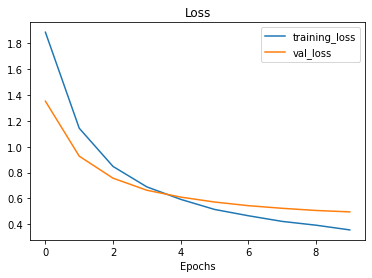

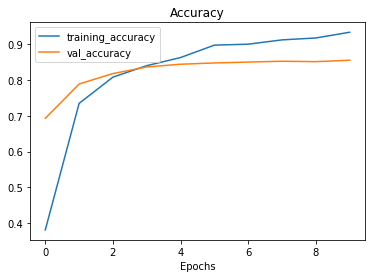

In [18]:
plot_loss_curves(model_0_history)

In [19]:
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling (Glo  (None, 1280)             0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


## Explanation

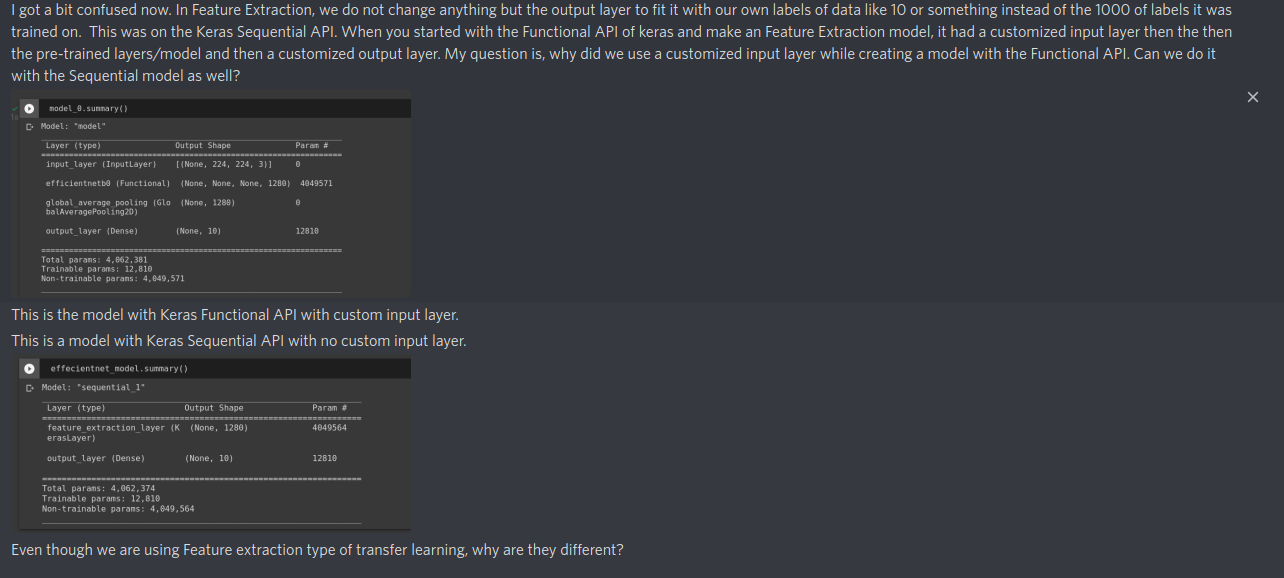

> This was the confusion I was having.

> This **model_0** is a transfer learning model using feature extraction. The difference here in **model_0** compared to previous model in the **transfer learning feature_extraction notebook** is that it had no **custom input layer**, only the output layer was changed to make it fit the number of classes as per the use case.

> But here in **model_0** we are using an **custom input layer** which is feeding our custom input to the **already pre-trained model** and an custom ouput layer to fit the number of classes as per the use case.

> So this is not limited to the **Keras Functional API**, I will try to replicate **model_0** with the **keras Sequential API** . I was tried it but it is giving me errors.



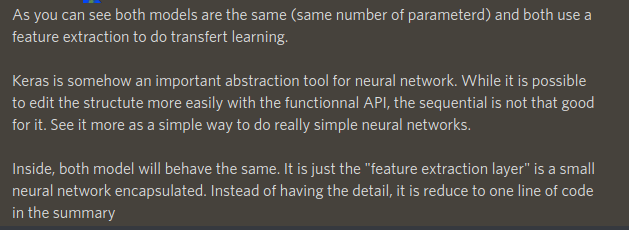








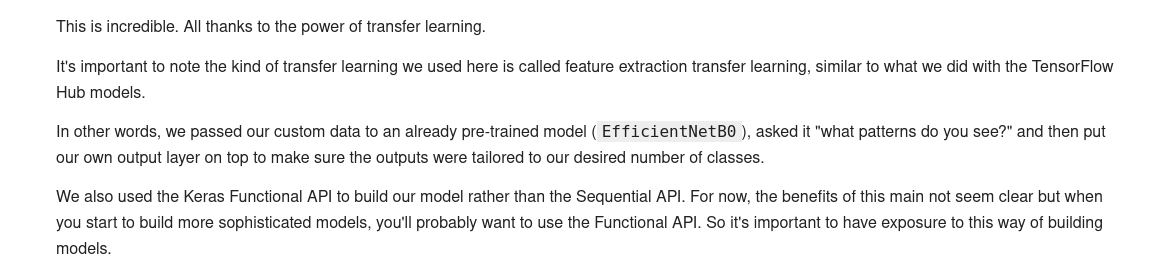

In [20]:
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                   

### Layers in the base model

In [21]:
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_dwcon

In [22]:
len(base_model.layers)

237

## Model_0 copy with Keras sequential API


> Replicating the **model_0** with the keras sequential API to use a custom input to feed the custom data to the already pre-trained model.

In [23]:
# import tensorflow as tf
# import tensorflow_hub as hub
# from tensorflow.keras import layers

In [24]:
# efficientnet_url='https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1'

In [25]:
# def create_model(model_url, num_classes=10):
#   """Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.
  
#   Args:
#     model_url (str): A TensorFlow Hub feature extraction URL.
#     num_classes (int): Number of output neurons in output layer,
#       should be equal to number of target classes, default 10.

#   Returns:
#     An uncompiled Keras Sequential model with model_url as feature
#     extractor layer and Dense output layer with num_classes outputs.
#   """
#   # Create an input layer to pass the custom data to the pretrained model
#   # inputs= tf.keras.layers.Input(shape=(224,224,3), name="input_layer")
#   inputs=layers.Dense(input_shape=(224,224,3), activation="relu" ,name="input_layer")

#   # Download the pretrained model and save it as a Keras layer
#   feature_extractor_layer = hub.KerasLayer(model_url,
#                                            trainable=True, # freeze the underlying patterns
#                                            name='feature_extraction_layer')
        
  
#   # Create our own model
#   model = tf.keras.Sequential([
#     inputs,   # Input layer
#     feature_extractor_layer, # use the feature extraction layer 
#     layers.Dense(num_classes, activation='softmax', name='output_layer') # create our own output layer      
#   ])

#   return model

In [26]:
# model_0_sequential=create_model(efficientnet_url)

In [27]:
# model_0_sequential.summary()

## Getting a feature vector from the trained model

> We have a tensor from the **base_model** which has a shape of (None,7,7,1280)

> When this tensor passes through the **GlobalAveragePooling2D**, then the shape is (None, 1280)

> Let's see wha the **GlGlobalAveragePooling2D** layer does.

In [28]:
input_shape=(1,4,4,3)
tf.random.set_seed(42)
input_tensor= tf.random.normal(input_shape)
print(f"Random Input Tensor: {input_tensor}\n")

global_average_pooled_tensor= tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor: {global_average_pooled_tensor}\n")

Random Input Tensor: [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D global average pooled random tensor: [[-0.09368646 -0.45840448 -0.2885598 ]]



In [29]:
input_tensor.shape

TensorShape([1, 4, 4, 3])

In [30]:
global_average_pooled_tensor.shape

TensorShape([1, 3])

In [31]:
newTensor= tf.reduce_mean(input_tensor, axis=[1,2])
newTensor,newTensor.shape

(<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>,
 TensorShape([1, 3]))

In [32]:
global_max_pooled_tensor= tf.keras.layers.GlobalMaxPooling2D()(input_tensor)
global_max_pooled_tensor, global_max_pooled_tensor.shape

(<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[0.9058464, 1.1603122, 1.6994323]], dtype=float32)>,
 TensorShape([1, 3]))

## More experiments with transfer Learning

* `model_1` -> Transfer learning with feature extraction with 1% of the traning data with data augmentation.

* `model_2` -> Transfer learning with feature extraction with 10% of the traning data with data augmentation.

* `model_3` -> Transfer learning with fine tuning on 10% of the traning data with data augmentation

* `model_4` -> Transfer learning with fine tuning on 100% of the traning data with data augmentation

> Same test dataset will be used in all the model experiments for a proper evaluation.

## Getting the data for model_1

In [33]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

--2022-07-29 14:20:53--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.119.128, 108.177.126.128, 142.250.145.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.119.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M   121MB/s    in 1.1s    

2022-07-29 14:20:54 (121 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [34]:
unzip_data('10_food_classes_1_percent.zip')

In [35]:
train_dir_1_per= '10_food_classes_1_percent/train'
test_dir= '10_food_classes_1_percent/test'

In [36]:
walk_through_dir('10_food_classes_1_percent')

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/test'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/sushi'

In [37]:
IMG_SIZE=(224,224)
BATCH_SIZE=32
train_data_1_per= tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_per, label_mode="categorical", image_size=IMG_SIZE, batch_size=BATCH_SIZE)

test_data= tf.keras.preprocessing.image_dataset_from_directory(test_dir, label_mode="categorical", image_size=IMG_SIZE, batch_size=BATCH_SIZE)


Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding Data Augmentation right into the model

`Docs` -> https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing

*`tf.keras.layers.experimental.preprocessing()`*

`Data Augmentation as a layer` -> https://www.tensorflow.org/tutorials/images/data_augmentation

In [38]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

In [39]:
data_augmentation= keras.Sequential([
                            preprocessing.RandomFlip("horizontal"),
                            preprocessing.RandomRotation(0.2),
                            preprocessing.RandomZoom(0.2),
                            preprocessing.RandomHeight(0.2),
                            preprocessing.RandomWidth(0.2),
                            # preprocessing.Rescaling(1./255) # Used for models like ResNetV2 but EfficientNet has rescale build-in
], name="data_augmentation")

### Visualizing the data augmentation layer

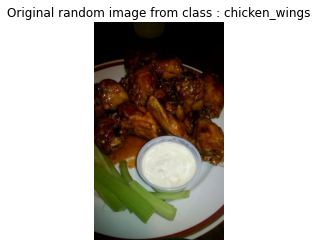

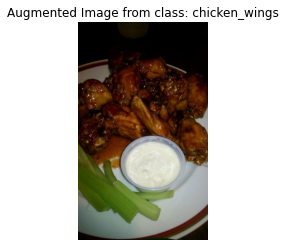

In [40]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

## Original Image
target_class= random.choice(train_data_1_per.class_names)
target_dir= train_dir_1_per + "/" + target_class
random_image= random.choice(os.listdir(target_dir))
random_image_path= target_dir + "/" + random_image
img= mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from class : {target_class}")
plt.axis(False);

## Augmented Image
plt.figure()
augmented_image= data_augmentation(img)
plt.imshow(augmented_image/255.)
plt.title(f"Augmented Image from class: {target_class}")
plt.axis(False);

In [41]:
train_data_1_per.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [42]:
train_dir_1_per + "/" + target_class


'10_food_classes_1_percent/train/chicken_wings'

In [43]:
target_class= random.choice(train_data_1_per.class_names)
target_class

'ice_cream'

### `Model_1`: Feature extraction with transfer learning with 1% of the data with data augmentation

In [44]:
input_shape=(224,224,3)
BATCH_SIZE=32

base_model= tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False

# Input Layer
inputs= layers.Input(shape=input_shape, name="input_layer")

# Add data augmentation as a layer
x= data_augmentation(inputs)

# Giving the inputs to base_model
x= base_model(x, training=False)

# Pool the output features of the base model
x=layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Dense layer as the output layer
outputs= layers.Dense(10, activation="softmax", name="output_layer")(x)

# Building the model
model_1= keras.Model(inputs, outputs)

# Compile model
model_1.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(), metrics=["accuracy"])

history_1_percent= model_1.fit(train_data_1_per, epochs=10, steps_per_epoch=len(train_data_1_per), validation_data=test_data, validation_steps=len(test_data), callbacks=[create_tensorboard_callback(dir_name="transfer_learning", experiment_name="1_percent_data_augmented")])

Saving TensorBoard log files to: transfer_learning/1_percent_data_augmented/20220729-142058
Epoch 1/10
3/3 [==============================] - 15s 4s/step - loss: 2.3760 - accuracy: 0.1000 - val_loss: 2.2331 - val_accuracy: 0.1700
Epoch 2/10
3/3 [==============================] - 7s 3s/step - loss: 2.1356 - accuracy: 0.2857 - val_loss: 2.1127 - val_accuracy: 0.2520
Epoch 3/10
3/3 [==============================] - 7s 3s/step - loss: 2.0135 - accuracy: 0.3571 - val_loss: 2.0084 - val_accuracy: 0.3288
Epoch 4/10
3/3 [==============================] - 7s 3s/step - loss: 1.8490 - accuracy: 0.4714 - val_loss: 1.9138 - val_accuracy: 0.3896
Epoch 5/10
3/3 [==============================] - 7s 3s/step - loss: 1.6333 - accuracy: 0.7000 - val_loss: 1.8283 - val_accuracy: 0.4372
Epoch 6/10
3/3 [==============================] - 7s 3s/step - loss: 1.5248 - accuracy: 0.7143 - val_loss: 1.7517 - val_accuracy: 0.4804
Epoch 7/10
3/3 [==============================] - 7s 3s/step - loss: 1.4172 - accurac

In [45]:
model_1.evaluate(test_data)

79/79 [==============================] - 6s 74ms/step - loss: 1.4914 - accuracy: 0.5988


[1.491429328918457, 0.598800003528595]

In [46]:
test_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [47]:
train_data_1_per

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [48]:
inputs

<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_layer')>

### `Model_1_512`: Feature extraction with transfer learning with 1% of the data with data augmentation but with `IMG_SIZE=(512,512)` 

In [49]:
IMG_SIZE=(512,512)
BATCH_SIZE=32
train_data_1_per_512= tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_per, label_mode="categorical", image_size=IMG_SIZE, batch_size=BATCH_SIZE)

test_data_512= tf.keras.preprocessing.image_dataset_from_directory(test_dir, label_mode="categorical", image_size=IMG_SIZE, batch_size=BATCH_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [50]:
input_shape=(512,512,3)
BATCH_SIZE=32

base_model_512= tf.keras.applications.EfficientNetB0(include_top=False)
base_model_512.trainable=False

# Input Layer
inputs= layers.Input(shape=input_shape, name="input_layer")

# Add data augmentation as a layer
x= data_augmentation(inputs)

# Giving the inputs to base_model
x= base_model_512(x, training=False)

# Pool the output features of the base model
x=layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Dense layer as the output layer
outputs= layers.Dense(10, activation="softmax", name="output_layer")(x)

# Building the model
model_1_512= keras.Model(inputs, outputs)

# Compile model
model_1_512.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(), metrics=["accuracy"])

history_1_percent_512= model_1_512.fit(train_data_1_per_512, epochs=10, steps_per_epoch=len(train_data_1_per_512), validation_data=test_data_512, validation_steps=len(test_data_512), callbacks=[create_tensorboard_callback(dir_name="transfer_learning", experiment_name="1_percent_data_augmented with (512,512) img_size")])

Saving TensorBoard log files to: transfer_learning/1_percent_data_augmented with (512,512) img_size/20220729-142242
Epoch 1/10
3/3 [==============================] - 41s 16s/step - loss: 2.3652 - accuracy: 0.0571 - val_loss: 2.2723 - val_accuracy: 0.1204
Epoch 2/10
3/3 [==============================] - 32s 15s/step - loss: 2.1305 - accuracy: 0.2429 - val_loss: 2.1650 - val_accuracy: 0.2072
Epoch 3/10
3/3 [==============================] - 32s 15s/step - loss: 1.9839 - accuracy: 0.3714 - val_loss: 2.0792 - val_accuracy: 0.2556
Epoch 4/10
3/3 [==============================] - 33s 15s/step - loss: 1.8218 - accuracy: 0.5429 - val_loss: 1.9995 - val_accuracy: 0.2988
Epoch 5/10
3/3 [==============================] - 32s 15s/step - loss: 1.6709 - accuracy: 0.6000 - val_loss: 1.9235 - val_accuracy: 0.3440
Epoch 6/10
3/3 [==============================] - 46s 22s/step - loss: 1.5655 - accuracy: 0.7286 - val_loss: 1.8459 - val_accuracy: 0.4040
Epoch 7/10
3/3 [==============================] - 

In [51]:
model_1_512.evaluate(test_data_512)

79/79 [==============================] - 27s 338ms/step - loss: 1.5904 - accuracy: 0.5796


[1.5903798341751099, 0.5795999765396118]

In [52]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (512, 306, 3)            0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [53]:
model_1_512.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 512, 512, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (512, 306, 3)            0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [54]:
results_1_percent_data_aug= model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 [==============================] - 6s 73ms/step - loss: 1.4914 - accuracy: 0.5988


[1.4914299249649048, 0.598800003528595]

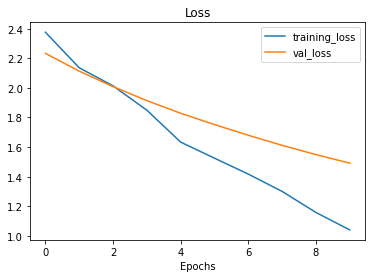

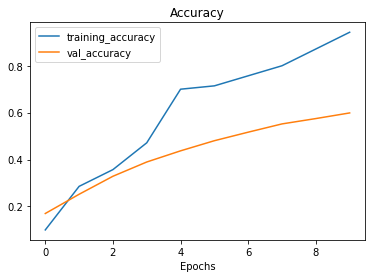

In [55]:
plot_loss_curves(history_1_percent)

### `Model_2`: Feature extraction with transfer learning with 10% of the data with data augmentation

In [56]:
IMG_SIZE=(224,224)
BATCH_SIZE=32

train_dir_10_per= "10_food_classes_10_percent/train"
test_dir='10_food_classes_10_percent/test'

train_data_10_per=tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir_10_per,image_size=IMG_SIZE, label_mode="categorical", batch_size=BATCH_SIZE)

test_data=tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,image_size=IMG_SIZE, label_mode="categorical", batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [57]:
walk_through_dir('10_food_classes_10_percent/')

There are 2 directories and 0 images in '10_food_classes_10_percent/'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percen

In [58]:
input_shape=(224,224,3)
BATCH_SIZE=32

base_model= tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False

# Input Layer
inputs= layers.Input(shape=input_shape, name="input_layer")

# Add data augmentation as a layer
x= data_augmentation(inputs)

# Giving the inputs to base_model
x= base_model(x, training=False)

# Pool the output features of the base model
x=layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Dense layer as the output layer
outputs= layers.Dense(10, activation="softmax", name="output_layer")(x)

# Building the model
model_2= keras.Model(inputs, outputs)

# Compile model
model_2.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(), metrics=["accuracy"])

history_2_percent= model_2.fit(train_data_10_per, epochs=10, steps_per_epoch=len(train_data_10_per), validation_data=test_data, validation_steps=len(test_data), callbacks=[create_tensorboard_callback(dir_name="transfer_learning", experiment_name="10_percent_data_augmented")])

Saving TensorBoard log files to: transfer_learning/10_percent_data_augmented/20220729-142949
Epoch 1/10
24/24 [==============================] - 21s 620ms/step - loss: 1.9893 - accuracy: 0.3733 - val_loss: 1.4772 - val_accuracy: 0.6520
Epoch 2/10
24/24 [==============================] - 14s 592ms/step - loss: 1.3598 - accuracy: 0.6627 - val_loss: 1.0692 - val_accuracy: 0.7456
Epoch 3/10
24/24 [==============================] - 13s 546ms/step - loss: 1.0451 - accuracy: 0.7520 - val_loss: 0.8710 - val_accuracy: 0.7824
Epoch 4/10
24/24 [==============================] - 13s 541ms/step - loss: 0.9221 - accuracy: 0.7840 - val_loss: 0.7708 - val_accuracy: 0.8016
Epoch 5/10
24/24 [==============================] - 12s 510ms/step - loss: 0.7943 - accuracy: 0.8000 - val_loss: 0.6997 - val_accuracy: 0.8144
Epoch 6/10
24/24 [==============================] - 12s 519ms/step - loss: 0.7363 - accuracy: 0.8080 - val_loss: 0.6588 - val_accuracy: 0.8204
Epoch 7/10
24/24 [==============================]

In [59]:
model_2.evaluate(test_data)

79/79 [==============================] - 6s 74ms/step - loss: 0.5686 - accuracy: 0.8300


[0.5686360597610474, 0.8299999833106995]

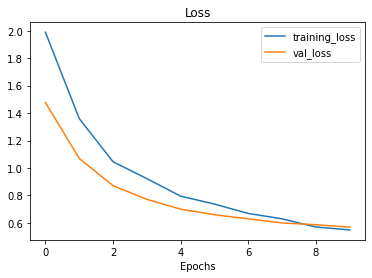

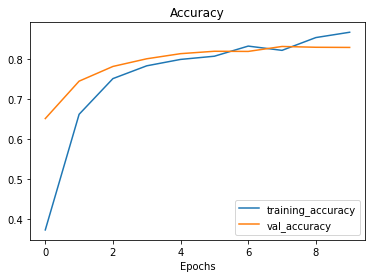

In [60]:
plot_loss_curves(history_2_percent)

In [61]:
results_2_percent_data_aug= model_2.evaluate(test_data)
results_2_percent_data_aug

79/79 [==============================] - 6s 74ms/step - loss: 0.5686 - accuracy: 0.8300


[0.5686360597610474, 0.8299999833106995]

In [62]:
results_1_percent_data_aug

[1.4914299249649048, 0.598800003528595]

In [63]:
model_2.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (512, 306, 3)            0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [64]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (512, 306, 3)            0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [65]:
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling (Glo  (None, 1280)             0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


#### Creating a ModelCheckpoint callback

`tf.keras.callbacks.ModelCheckpoint()`

> It intermdediately saves the model(the full model or just the weights) during training. This is useful so that we can come and start from where we left off.

In [66]:
checkpoint_path='ten_percent_model_checkpoints_weights/checkpoint.ckpt'

# ModelCheckpoint callback(Just save the model's weights only)
checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, save_best_only=True, save_freq="epoch", verbose=1)

### `model_2` again but with ModelCheckpoint callaback added

In [67]:
input_shape=(224,224,3)
BATCH_SIZE=32

base_model= tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False

# Input Layer
inputs= layers.Input(shape=input_shape, name="input_layer")

# Add data augmentation as a layer
x= data_augmentation(inputs)

# Giving the inputs to base_model
x= base_model(x, training=False)

# Pool the output features of the base model
x=layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Dense layer as the output layer
outputs= layers.Dense(10, activation="softmax", name="output_layer")(x)

# Building the model
model_2_checkpoint= keras.Model(inputs, outputs)

# Compile model
model_2_checkpoint.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(), metrics=["accuracy"])

history_2_checkpoint_percent= model_2_checkpoint.fit(train_data_10_per, epochs=10, steps_per_epoch=len(train_data_10_per), validation_data=test_data, validation_steps=len(test_data), callbacks=[create_tensorboard_callback(dir_name="transfer_learning", experiment_name="10_percent_data_augmented"), checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_augmented/20220729-143310
Epoch 1/10
24/24 [==============================] - ETA: 0s - loss: 2.0196 - accuracy: 0.3000WARNING:tensorflow:Model was constructed with shape (512, 306, 3) for input KerasTensor(type_spec=TensorSpec(shape=(512, 306, 3), dtype=tf.uint8, name='random_flip_input'), name='random_flip_input', description="created by layer 'random_flip_input'"), but it was called on an input with incompatible shape (None, 224, 224, 3).

Epoch 1: val_loss improved from inf to 1.46061, saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 19s 577ms/step - loss: 2.0196 - accuracy: 0.3000 - val_loss: 1.4606 - val_accuracy: 0.6340
Epoch 2/10
24/24 [==============================] - ETA: 0s - loss: 1.3768 - accuracy: 0.6440
Epoch 2: val_loss improved from 1.46061 to 1.04729, saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [=============

In [68]:
model_0.evaluate(test_data)

79/79 [==============================] - 7s 73ms/step - loss: 0.4958 - accuracy: 0.8552


[0.4958018958568573, 0.8551999926567078]

In [69]:
model_1.evaluate(test_data)

79/79 [==============================] - 6s 73ms/step - loss: 1.4914 - accuracy: 0.5988


[1.4914295673370361, 0.598800003528595]

In [70]:
model_2.evaluate(test_data)

79/79 [==============================] - 6s 74ms/step - loss: 0.5686 - accuracy: 0.8300


[0.5686360597610474, 0.8299999833106995]

In [71]:
model_2_checkpoint.evaluate(test_data)

79/79 [==============================] - 6s 75ms/step - loss: 0.5518 - accuracy: 0.8420


[0.5517827272415161, 0.8420000076293945]

In [72]:
results_2_percent_checkpoint_data_aug= model_2_checkpoint.evaluate(test_data)
results_2_percent_checkpoint_data_aug

79/79 [==============================] - 6s 73ms/step - loss: 0.5518 - accuracy: 0.8420


[0.5517827868461609, 0.8420000076293945]

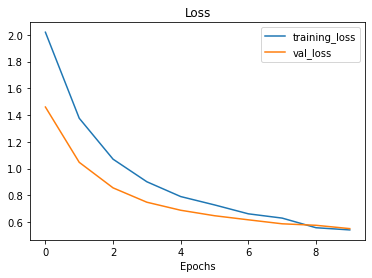

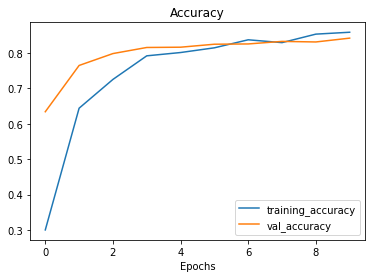

In [73]:
plot_loss_curves(history_2_checkpoint_percent)

### Loading the Checkpointed weights

> Loading in checkpointed weights returns a model to a specific checkpoint

#### Load in saved model weights and evaluate model

In [74]:
model_2_checkpoint.weights

[<tf.Variable 'normalization_4/mean:0' shape=(3,) dtype=float32, numpy=array([0.485, 0.456, 0.406], dtype=float32)>,
 <tf.Variable 'normalization_4/variance:0' shape=(3,) dtype=float32, numpy=array([0.229, 0.224, 0.225], dtype=float32)>,
 <tf.Variable 'normalization_4/count:0' shape=() dtype=int64, numpy=0>,
 <tf.Variable 'stem_conv/kernel:0' shape=(3, 3, 3, 32) dtype=float32, numpy=
 array([[[[ 2.07668245e-02,  8.53624821e-01, -9.72171009e-01,
            5.80005467e-01,  3.13335508e-02, -1.81043148e-02,
           -1.28635168e-02,  5.94060645e-02, -7.41896749e-01,
           -2.27897346e-01,  2.00766921e-01, -2.33019665e-02,
           -3.82314444e-01, -1.13366711e+00, -4.97356057e-02,
           -5.28575480e-01,  6.01686649e-02,  3.28413874e-01,
            7.26403654e-01,  9.56093222e-02,  2.53003836e-03,
            7.99428642e-01,  1.60467178e-01,  1.51992925e-02,
            2.15564728e-01, -6.15406692e-01,  7.56446272e-02,
            3.47692966e-02,  0.00000000e+00, -6.2799476

In [75]:
len(model_2_checkpoint.weights)

314

In [76]:
model_2_checkpoint.load_weights(checkpoint_path)

#### Evaluating the model with the loaded_weights from the `Modelchcekpoint callback`

In [77]:
loaded_weights_model_results= model_2_checkpoint.evaluate(test_data)

79/79 [==============================] - 6s 74ms/step - loss: 0.5518 - accuracy: 0.8420


In [78]:
results_2_percent_checkpoint_data_aug

[0.5517827868461609, 0.8420000076293945]

In [79]:
loaded_weights_model_results == results_2_percent_checkpoint_data_aug

False

### `Model_3`: Fine Tuning with transfer learning with 10% of the data with data augmentation

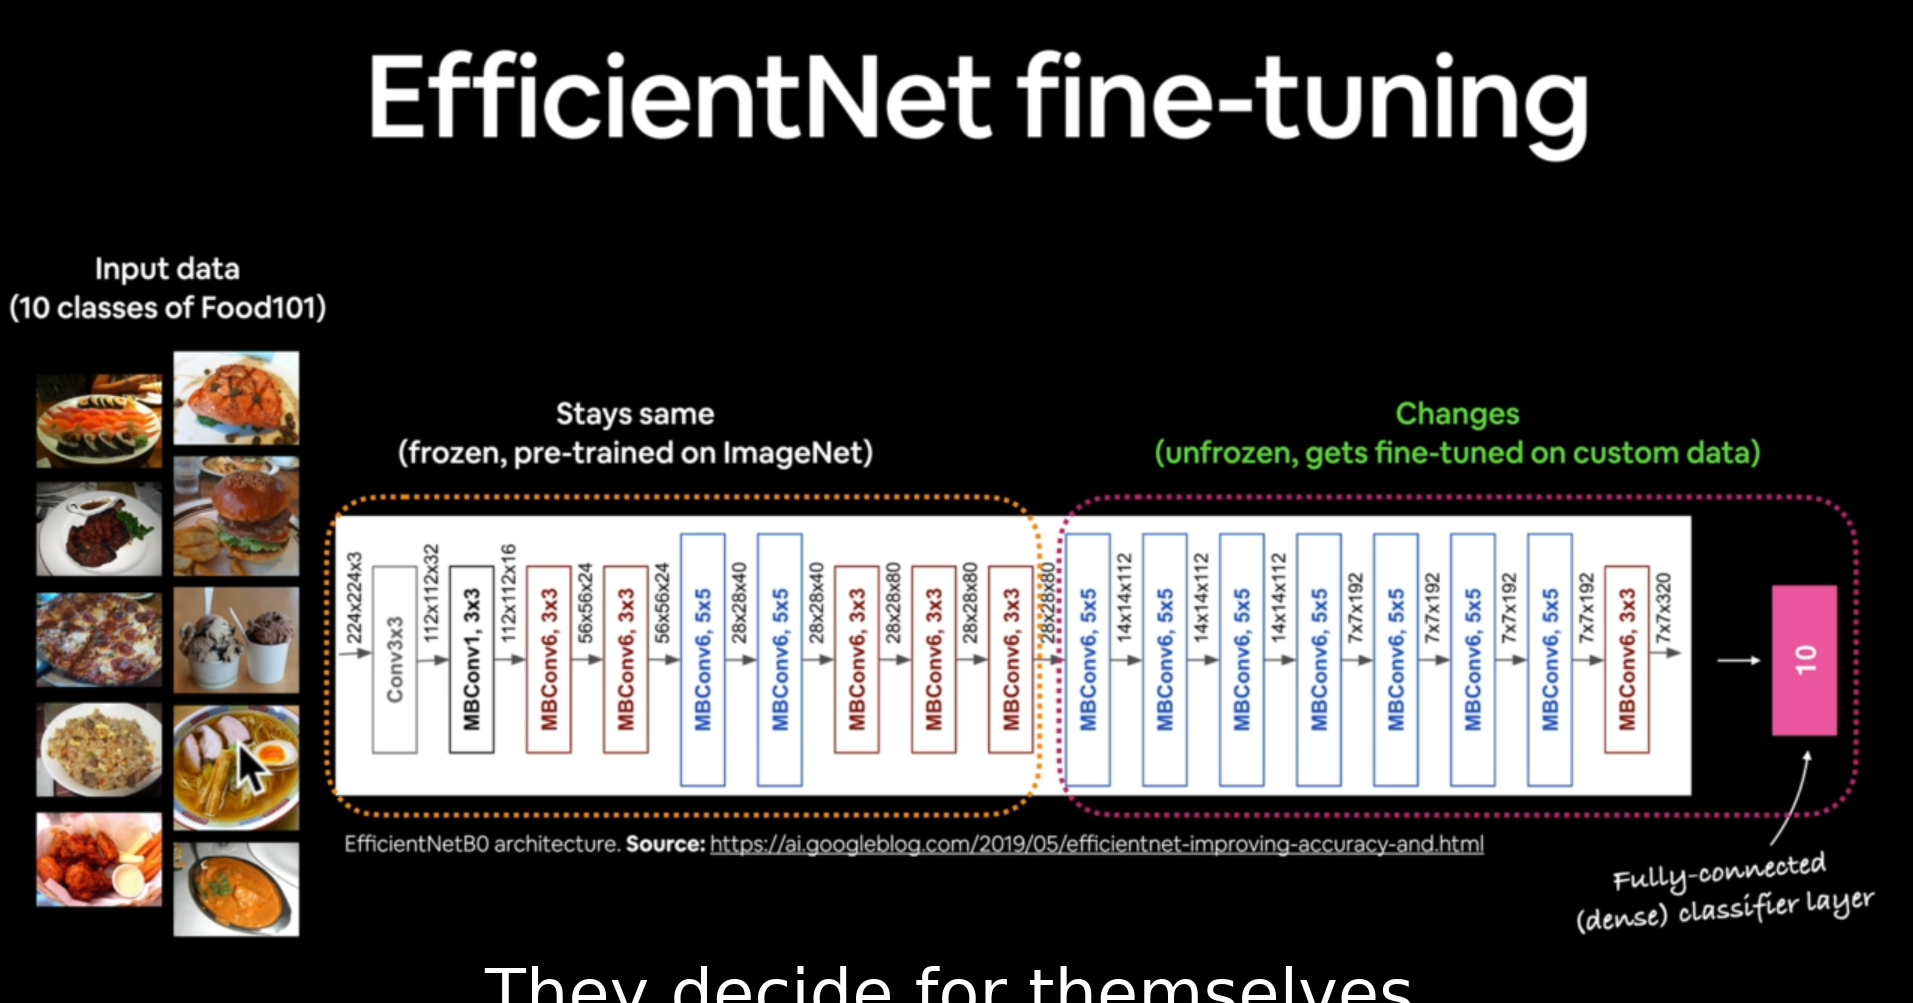



> Fine -tuning usually works best after training a feature extraction model for a few epochs with large amounts of custom data.